In [ ]:
import gym
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

torch.manual_seed(357)
np.random.seed(357)  # For numpy operations
random.seed(357)     # For Python's random module

In [ ]:
class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, env, height=84, width=84, grayscale=True):
        super(PreprocessFrame, self).__init__(env)
        self.height = height
        self.width = width
        self.grayscale = grayscale
        channels = 1 if grayscale else 3
        self.observation_space = gym.spaces.Box(low=0, high=1.0,
                                                shape=(self.height, self.width),
                                                dtype=np.float32)
        
    def observation(self, obs):
        if self.grayscale:
            obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        obs = cv2.resize(obs, (self.width, self.height), interpolation=cv2.INTER_AREA)
        obs = obs.astype(np.float32) / 255.0
        return obs
      
class ActorCritic(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        def conv2d_size_out(size, kernel_size, stride):
            return (size - kernel_size) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64
        
        self.fc = nn.Linear(linear_input_size, 512)
        self.policy = nn.Linear(512, num_actions)
        self.value = nn.Linear(512, 1)
        
    def forward(self, x):
        # x shape expected: (batch, channels, height, width)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return self.policy(x), self.value(x)

class PPOAgent:
    def __init__(self, env, input_channels, num_actions, 
                 lr=2.5e-4, gamma=0.99, lam=0.95, clip_epsilon=0.1, 
                 update_epochs=4, mini_batch_size=32, rollout_length=256, 
                 ent_coef=0.01, max_grad_norm=0.5):
        self.env = env
        self.gamma = gamma
        self.lam = lam
        self.clip_epsilon = clip_epsilon
        self.update_epochs = update_epochs
        self.mini_batch_size = mini_batch_size
        self.rollout_length = rollout_length
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm

        self.num_actions = num_actions
        self.actor_critic = ActorCritic(input_channels, num_actions).to(device)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        
    def select_action(self, obs):
        obs_array = np.array(obs)
        # Expected shapes:
        #   Channel-last: (84, 84, 4)
        #   Channel-first: (4, 84, 84)
        if obs_array.ndim == 3 and obs_array.shape[-1] == 4:
            obs_tensor = torch.FloatTensor(obs_array).permute(2, 0, 1).unsqueeze(0).to(device)
        elif obs_array.ndim == 3 and obs_array.shape[0] == 4:
            obs_tensor = torch.FloatTensor(obs_array).unsqueeze(0).to(device)
        else:
            raise ValueError("Unexpected observation shape: {}".format(obs_array.shape))
        
        policy_logits, value = self.actor_critic(obs_tensor)
        dist = Categorical(logits=policy_logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item(), value.item()
    
    def compute_gae(self, rewards, values, dones, next_value):
        advantages = []
        gae = 0
        values = values + [next_value]
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * values[step+1] * (1 - dones[step]) - values[step]
            gae = delta + self.gamma * self.lam * (1 - dones[step]) * gae
            advantages.insert(0, gae)
        returns = [adv + val for adv, val in zip(advantages, values[:-1])]
        return advantages, returns
    
    def collect_rollout(self):
        obs = self.env.reset()
        states, actions, log_probs, rewards, dones, values = [], [], [], [], [], []
        for _ in range(self.rollout_length):
            states.append(obs)
            action, log_prob, value = self.select_action(obs)
            actions.append(action)
            log_probs.append(log_prob)
            values.append(value)
            obs, reward, done, _ = self.env.step(action)
            rewards.append(reward)
            dones.append(done)
            if done:
                obs = self.env.reset()
        return states, actions, log_probs, rewards, dones, values
    
    def ppo_update(self, states, actions, log_probs, returns, advantages):
        states = np.array(states)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        old_log_probs = torch.tensor(log_probs, dtype=torch.float32, device=device)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Convert states from (num_steps, H, W, C) or (num_steps, C, H, W) to (num_steps, C, H, W)
        if states.shape[-1] == 4:  # channel-last case
            states_tensor = torch.FloatTensor(states).permute(0, 3, 1, 2).to(device)
        else:
            states_tensor = torch.FloatTensor(states).to(device)
        
        dataset_size = states_tensor.size(0)
        indices = np.arange(dataset_size)
        for _ in range(self.update_epochs):
            np.random.shuffle(indices)
            for start in range(0, dataset_size, self.mini_batch_size):
                end = start + self.mini_batch_size
                mb_idx = indices[start:end]
                
                batch_states = states_tensor[mb_idx]
                batch_actions = actions[mb_idx]
                batch_old_log_probs = old_log_probs[mb_idx]
                batch_returns = returns[mb_idx]
                batch_advantages = advantages[mb_idx]
                
                policy_logits, values = self.actor_critic(batch_states)
                dist = Categorical(logits=policy_logits)
                new_log_probs = dist.log_prob(batch_actions)
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages

                dist = Categorical(logits=policy_logits)
                entropy = dist.entropy().mean()

                policy_loss = -torch.min(surr1, surr2).mean() - self.ent_coef * entropy 
                value_loss = F.mse_loss(values.squeeze(-1), batch_returns)
                
                loss = policy_loss + 0.5 * value_loss
                
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.max_grad_norm)
                self.optimizer.step()
    
    def train(self, total_updates=1000):
        
        episode_rewards = []
        all_rewards = []
        
        for update in range(1, total_updates + 1):
            states, actions, log_probs, rewards, dones, values = self.collect_rollout()
            
            if dones[-1]:
                next_value = 0
            else:
                last_obs = states[-1]
                obs_array = np.array(last_obs)
                if obs_array.ndim == 3 and obs_array.shape[-1] == 4:
                    obs_tensor = torch.FloatTensor(obs_array).permute(2, 0, 1).unsqueeze(0).to(device)
                else:
                    obs_tensor = torch.FloatTensor(obs_array).unsqueeze(0).to(device)
                _, next_value = self.actor_critic(obs_tensor)
                next_value = next_value.item()
            
            advantages, returns = self.compute_gae(rewards, values, dones, next_value)
            self.ppo_update(states, actions, log_probs, returns, advantages)
            
            total_reward = sum(rewards)
            episode_rewards.append(total_reward)
            all_rewards.append(total_reward)
            
            if update % 50 == 0:
                avg_reward = np.mean(episode_rewards[-50:])
                print(f"Update {update}: Avg Reward (last 50): {avg_reward:.2f}")
        
        return all_rewards

In [ ]:
def plot_results(results, title="Training Performance", window=50):
    plt.figure(figsize=(12, 8))
    for key, rewards in results.items():
        rolling_rewards = []
        for run in rewards:
            roll = np.convolve(run, np.ones(window)/window, mode='valid')
            rolling_rewards.append(roll)
        rolling_rewards = np.array(rolling_rewards)
        mean_rolling = np.mean(rolling_rewards, axis=0)
        std_rolling = np.std(rolling_rewards, axis=0)
        episodes = np.arange(len(mean_rolling)) + window - 1

        plt.plot(episodes, mean_rolling, label=key)
        plt.fill_between(episodes, 
                        mean_rolling - std_rolling, 
                        mean_rolling + std_rolling, 
                        alpha=0.2)

    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(f"Total Reward ({window}-episode Rolling Mean)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

env = gym.make('MsPacman-v0')
env = PreprocessFrame(env)
env = gym.wrappers.FrameStack(env, num_stack=4)

num_actions = env.action_space.n
input_channels = 4

def run_experiment(hparams_list, num_runs=3, total_updates=1000):
    
    results = {}
    
    for hparams in hparams_list:
        print(f"\nRunning experiment with: {hparams}")
        run_rewards = []
        
        for run in range(num_runs):
            agent = PPOAgent(env, input_channels, num_actions, **hparams)
            rewards = agent.train(total_updates)
            run_rewards.append(rewards)
            
            # Save model weights
            os.makedirs("models", exist_ok=True)
            hparam_str = "_".join(f"{k}_{v}" for k,v in hparams.items())
            torch.save(agent.actor_critic.state_dict(), 
                     f"models/ppo_{hparam_str}_run{run}.pth")
        
        results[str(hparams)] = run_rewards
    
    return results

Using device: cpu


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment MsPacman-v0 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/MsPacman-v5`.
  logger.warn(



Running experiment with: {'lr': 0.00025, 'gamma': 0.995, 'lam': 0.95, 'clip_epsilon': 0.15, 'update_epochs': 4, 'mini_batch_size': 128, 'rollout_length': 1024, 'ent_coef': 0.01, 'max_grad_norm': 0.5}
Update 50: Avg Reward (last 50): 400.00
Update 100: Avg Reward (last 50): 519.20
Update 150: Avg Reward (last 50): 552.80
Update 200: Avg Reward (last 50): 557.20
Update 250: Avg Reward (last 50): 670.00
Update 300: Avg Reward (last 50): 581.20
Update 350: Avg Reward (last 50): 496.40
Update 400: Avg Reward (last 50): 278.00
Update 450: Avg Reward (last 50): 497.80
Update 500: Avg Reward (last 50): 570.00
Update 550: Avg Reward (last 50): 710.20
Update 600: Avg Reward (last 50): 650.20
Update 650: Avg Reward (last 50): 533.20
Update 700: Avg Reward (last 50): 409.20
Update 750: Avg Reward (last 50): 414.20
Update 800: Avg Reward (last 50): 422.20
Update 850: Avg Reward (last 50): 366.40
Update 900: Avg Reward (last 50): 505.40
Update 950: Avg Reward (last 50): 469.40
Update 1000: Avg Rewa

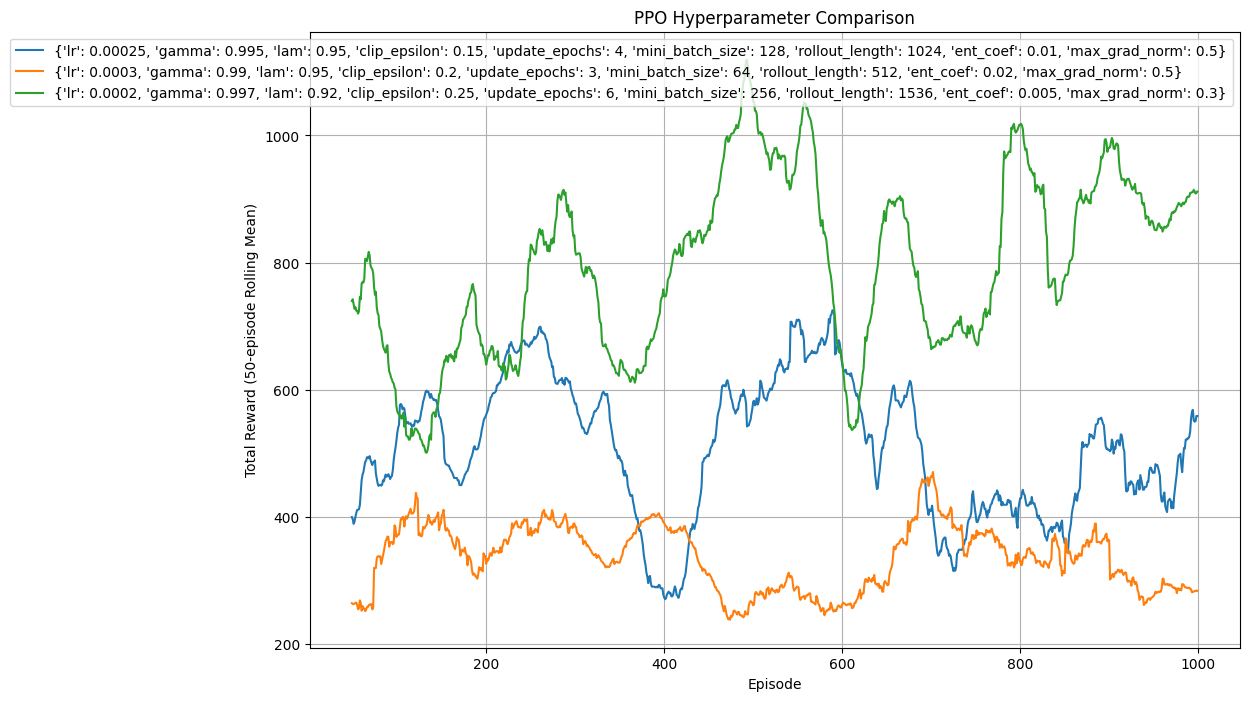

In [ ]:
hparams_list = [
    # Balanced Config
    {
        "lr": 2.5e-4,
        "gamma": 0.995,       # Better long-term credit
        "lam": 0.95,
        "clip_epsilon": 0.15,
        "update_epochs": 4,
        "mini_batch_size": 128,
        "rollout_length": 1024,  # Sweet spot for Atari
        "ent_coef": 0.01,
        "max_grad_norm": 0.5
    },
    # Fast training    
    {
        "lr": 3e-4,           # Slightly higher learning rate
        "gamma": 0.99,        # Standard discount
        "lam": 0.95,          # Default GAE
        "clip_epsilon": 0.2,  # More aggressive updates
        "update_epochs": 3,   # Faster updates
        "mini_batch_size": 64, 
        "rollout_length": 512,  # Shorter rollouts
        "ent_coef": 0.02,     # Higher exploration
        "max_grad_norm": 0.5
    },
    # Aggressive Learning Config
    {
        "lr": 2e-4,
        "gamma": 0.997,       # Very long-term focus
        "lam": 0.92,          # Slightly lower GAE
        "clip_epsilon": 0.25, # More radical updates
        "update_epochs": 6,
        "mini_batch_size": 256,
        "rollout_length": 1536,
        "ent_coef": 0.005,    # Lower exploration over time
        "max_grad_norm": 0.3  # Tighter gradient control
    }
]

# Run experiments and plot results
results = run_experiment(hparams_list, num_runs=1, total_updates=1000)

In [ ]:
plot_results(results, "PPO Hyperparameter Comparison")